---
title: Logistic Regression II
---

::: {note} Learning Outcomes
* Apply decision rules to make a classification
* Learn when logistic regression works well and when it does not
* Introduce new metrics for model performance
:::

Today, we will continue studying the Logistic Regression model and discuss decision boundaries that help inform the classification of a particular prediction and learn about linear separability. Starting off from cross-entropy loss, we'll study a few of its pitfalls, and learn potential remedies. We will also provide an implementation of `sklearn`'s logistic regression model. Lastly, we'll return to decision rules and discuss metrics that allow us to determine our model's performance in different scenarios. 

This will introduce us to the process of **thresholding** -- a technique used to *classify* data from our model's predicted probabilities, or $P(Y=1|x)$. In doing so, we'll focus on how these thresholding decisions affect the behavior of our model and learn various evaluation metrics useful for binary classification, and apply them to our study of logistic regression.

## Cross-Entropy Loss

To quantify the error of our logistic regression model, we'll need to define a new loss function. 

### Why Not MSE?
You may wonder: why not use our familiar mean squared error? It turns out that the MSE is not well suited for logistic regression. To see why, let's consider a simple, artificially generated `toy` dataset with just one feature (this will be easier to work with than the more complicated `games` data).

````{dropdown} Click to see the code
```python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
```
````


In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

````{dropdown} Click to see the code
```python
toy_df = pd.DataFrame({
        "x": [-4, -2, -0.5, 1, 3, 5],
        "y": [0, 0, 1, 0, 1, 1]})
toy_df.head()
```
````

In [8]:
toy_df = pd.DataFrame({
        "x": [-4, -2, -0.5, 1, 3, 5],
        "y": [0, 0, 1, 0, 1, 1]})
toy_df.head()

,x,y
0,-4.0,0
1,-2.0,0
2,-0.5,1
3,1.0,0
4,3.0,1


We'll construct a basic logistic regression model with only one feature and no intercept term. Our predicted probabilities take the form:

$$p=\hat{P}_\theta(Y=1|x)= \sigma({x^{T}\theta}) = \frac{1}{1+e^{-\theta_1 x}}$$

In the cell below, we plot the MSE for our model on the data.

````{dropdown} Click to see the code
```python
#| fig-alt: MSE on toy classification data
def sigmoid(z):
    return 1/(1+np.e**(-z))
    
def mse_on_toy_data(theta):
    p_hat = sigmoid(toy_df['x'] * theta)
    return np.mean((toy_df['y'] - p_hat)**2)

thetas = np.linspace(-15, 5, 100)
plt.plot(thetas, [mse_on_toy_data(theta) for theta in thetas])
plt.title("MSE on toy classification data")
plt.xlabel(r'$\theta_1$')
plt.ylabel('MSE');
```
````

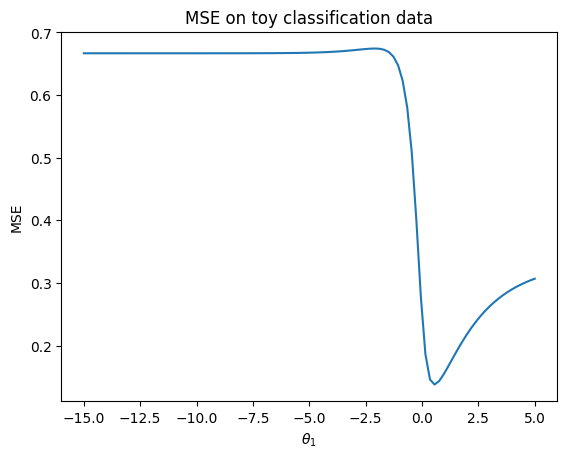

In [9]:
#| fig-alt: MSE on toy classification data
def sigmoid(z):
    return 1/(1+np.e**(-z))
    
def mse_on_toy_data(theta):
    p_hat = sigmoid(toy_df['x'] * theta)
    return np.mean((toy_df['y'] - p_hat)**2)

thetas = np.linspace(-15, 5, 100)
plt.plot(thetas, [mse_on_toy_data(theta) for theta in thetas])
plt.title("MSE on toy classification data")
plt.xlabel(r'$\theta_1$')
plt.ylabel('MSE');

This looks nothing like the parabola we found when plotting the MSE of a linear regression model! In particular, we can identify two flaws with using the MSE for logistic regression:

1. The MSE loss surface is *non-convex*. There is both a global minimum and a (barely perceptible) local minimum in the loss surface above. This means that there is the risk of gradient descent converging on the local minimum of the loss surface, missing the true optimum parameter $\theta_1$.

```{image} images/global_local_min.png
:alt: MSE on toy classification data showing two possible minima
:width: 400
```

2. Squared loss is *bounded* for a classification task. MSE never gets very large, because both response and predicted probability are bounded by 1. Recall that each true $y$ has a value of either 0 or 1. This means that even if our model makes the worst possible prediction (e.g. predicting $p=0$ for $y=1$), the squared loss for an observation will be no greater than 1: $$(y-p)^2=(1-0)^2=1$$ The MSE does not strongly penalize poor predictions.

```{image} images/squared_loss.png
:alt: Graph of squared loss for one individual showing a downward sloping curve
:width:400
```

### Motivating Cross-Entropy Loss
Suffice to say, we don't want to use the MSE when working with logistic regression. Instead, we'll consider what kind of behavior we would *like* to see in a loss function.

Let $y$ be the binary label (it can either be 0 or 1), and $p$ be the model's predicted probability of the label $y$ being 1. 

* When the true $y$ is 1, we should incur *low loss* when the model predicts *large* $p$
* When the true $y$ is 0, we should incur *high loss* when the model predicts *large* $p$

In other words, our loss function should behave differently depending on the value of the true class, $y$. 

The **cross-entropy loss** incorporates this changing behavior. We will use it throughout our work on logistic regression. Below, we write out the cross-entropy loss for a *single* datapoint (no averages just yet). Again let $y$ be a binary label {0, 1}, and $p$ be the probability of the label being 1.

$$\text{Cross-Entropy Loss} = \begin{cases}
  -\log{(p)}  & \text{if } y=1 \\
  -\log{(1-p)} & \text{if } y=0
\end{cases}
$$

Why does this (seemingly convoluted) loss function "work"? Let's break it down.

| When $y=1$ | When $y=0$ | 
| -- | -- | 
| ![cross-entropy loss when Y=1](images/y=1.png) | ![cross-entropy loss when Y=0](images/y=0.png) |
| As $p \rightarrow 0$, loss approches $\infty$ | As $p \rightarrow 0$, loss approches 0 | 
|  As $p \rightarrow 1$, loss approaches 0 | As $p \rightarrow 1$, loss approaches $\infty$ | 

All good – we are seeing the behavior we want for our logistic regression model.

The piecewise function we outlined above is difficult to optimize: we don't want to constantly "check" which form of the loss function we should be using at each step of choosing the optimal model parameters. We can re-express cross-entropy loss in a more convenient way:

$$\text{Cross-Entropy Loss} = -\left(y\log{(p)}+(1-y)\log{(1-p)}\right)$$

By setting $y$ to 0 or 1, we see that this new form of cross-entropy loss gives us the same behavior as the original formulation. Another way to think about this is that in either scenario (y being equal to 0 or 1), only one of the cross-entropy loss terms is activated, which gives us a convenient way to combine the two independent loss functions.

| When $y=1$ | | When $y=0$ |
| :--- | :---: | :--- |
| $$\begin{aligned} \text{CE} &= -\left((1)\log{(p)}+(1-1)\log{(1-p)}\right) \\ &= -\log{(p)} \end{aligned}$$ | | $$\begin{aligned} \text{CE} &= -\left((0)\log{(p)}+(1-0)\log{(1-p)}\right) \\ &= -\log{(1-p)} \end{aligned}$$ |

The empirical risk of the logistic regression model is then the mean cross-entropy loss across all datapoints in the dataset. When fitting the model, we want to determine the model parameter $\theta$ that leads to the lowest mean cross-entropy loss possible. For logistic regression, the empirical risk over a sample of size n is:

$$
\begin{align}
R(\theta) &= - \frac{1}{n} \sum_{i=1}^n \left(y_i\log{(p_i)}+(1-y_i)\log{(1-p_i)}\right) \\
&= - \frac{1}{n} \sum_{i=1}^n \left(y_i\log{\sigma(\mathbb{X}_i^{\top}\theta)}+(1-y_i)\log{(1-\sigma(\mathbb{X}_i^{\top}\theta))}\right)
\end{align}
$$

The optimization problem is therefore to find the estimate $\hat{\theta}$ that minimizes $R(\theta)$:

$$
\hat{\theta} = \underset{\theta}{\arg\min} - \frac{1}{n} \sum_{i=1}^n \left(y_i\log{(\sigma(\mathbb{X}_i^{\top}\theta))}+(1-y_i)\log{(1-\sigma(\mathbb{X}_i^{\top}\theta))}\right) 
$$

Plotting the cross-entropy loss surface for our `toy` dataset gives us a more encouraging result – our loss function is now convex. This means we can optimize it using gradient descent. Computing the gradient of the logistic model is fairly challenging, so we'll let `sklearn` take care of this for us. You won't need to compute the gradient of the logistic model in Data 100.

````{dropdown} Click to see the code
```python
#| fig-alt: Mean Cross Entropy Loss
def cross_entropy(y, p_hat):
    return - y * np.log(p_hat) - (1 - y) * np.log(1 - p_hat)

def mean_cross_entropy_on_toy_data(theta):
    p_hat = sigmoid(toy_df['x'] * theta)
    return np.mean(cross_entropy(toy_df['y'], p_hat))

plt.plot(thetas, [mean_cross_entropy_on_toy_data(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy Loss($\theta$)')
plt.xlabel(r'$\theta$');
```
````

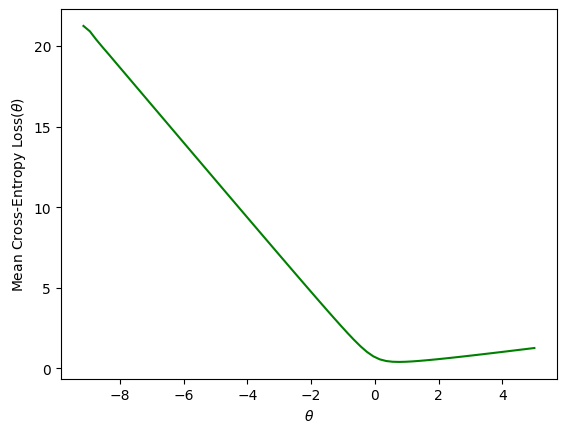

In [10]:
#| fig-alt: Mean Cross Entropy Loss
def cross_entropy(y, p_hat):
    return - y * np.log(p_hat) - (1 - y) * np.log(1 - p_hat)

def mean_cross_entropy_on_toy_data(theta):
    p_hat = sigmoid(toy_df['x'] * theta)
    return np.mean(cross_entropy(toy_df['y'], p_hat))

plt.plot(thetas, [mean_cross_entropy_on_toy_data(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy Loss($\theta$)')
plt.xlabel(r'$\theta$');

## Review : Decision Boundaries
Let's start with a recap of decision boundaries that we covered at the end of the previous lecture. In logistic regression, we model the *probability* that a datapoint belongs to Class 1. 

```{image} images/log_reg_summary.png
:alt: The input is numeric features, the model is a linear combination transformed by a sigmoid, then comes a decision rule followed by an output class.
:width: 800
```

In the last lecture, we developed the logistic regression model to predict that probability, but we never actually made any *classifications* for whether our prediction $y$ belongs in Class 0 or Class 1. 

$$ p = \hat{P}_\theta(Y=1 | x) = \frac{1}{1 + e^{-x^{\top}\theta}}$$

A **decision rule** tells us how to interpret the output of the model to make a decision on how to classify a datapoint. We commonly make decision rules by specifying a **threshold**, $T$. If the predicted probability is greater than or equal to $T$, predict Class 1. Otherwise, predict Class 0. 

$$\hat y = \text{classify}(x) = \begin{cases}
        \text{Class 1}, & p \ge T\\
        \text{Class 0}, & p < T
    \end{cases}
$$
    
The threshold is often set to $T = 0.5$, but *not always*. We'll discuss why we might want to use other thresholds  $T \neq 0.5$ later in this lecture.

Using our decision rule, we can define a **decision boundary** as the “line” that splits the data into classes based on its features. For logistic regression, since we are working in $p$ dimensions, the decision boundary is a **hyperplane** -- a linear combination of the features in $p$-dimensions -- and we can recover it from the final logistic regression model. For example, if we have a model with 2 features (2D), we have $\theta = [\theta_0, \theta_1, \theta_2]$ including the intercept term, and we can solve for the decision boundary like so: 

$$
\begin{align}
T &= \frac{1}{1 + e^{-(\theta_0 + \theta_1 * \text{feature1} +  \theta_2 * \text{feature2})}} \\
1 + e^{-(\theta_0 + \theta_1 \cdot \text{feature1} +  \theta_2  \cdot  \text{feature2})} &= \frac{1}{T} \\
e^{-(\theta_0 + \theta_1  \cdot  \text{feature1} +  \theta_2  \cdot  \text{feature2})} &= \frac{1}{T} - 1 \\
\theta_0 + \theta_1  \cdot  \text{feature1} +  \theta_2  \cdot  \text{feature2} &= -\log(\frac{1}{T} - 1)
\end{align} 
$$


For a model with 2 features, the decision boundary is a line in terms of its features. Let's prove this by again looking at the basketball example from the previous lecture where our two features are `GOAL_DIFF` and `AST`. Rewriting the previous equation in terms of these features, we get the following:

$$\theta_0 + \theta_1  \cdot  \text{GOAL\_DIFF} +  \theta_2  \cdot  \text{AST} = -\log(\frac{1}{T} - 1)$$

Now if we assume that the threshold T = 0.5, then $\log(\frac{1}{0.5} - 1) = \log(1) = 0$, so substituting this in and rearranging terms, we get the following:

$$
\begin{align}
0 &= \theta_0 + \theta_1  \cdot  \text{GOAL\_DIFF} +  \theta_2  \cdot  \text{AST} \\
\text{AST} &= \frac{\theta_0 + \theta_1  \cdot  \text{GOAL\_DIFF}}{-\theta_2}
\end{align}
$$

This is the equation of a line of form $y=mx+b$ relating `AST` to `GOAL_DIFF`, so we've just proved that the decision boundary is a **hyperplane** that can split points into two classes! To make it easier to visualize, we've included an example of a 1-dimensional and a 2-dimensional decision boundary below. Notice how the decision boundary predicted by our logistic regression model perfectly separates the points into two classes. Here the color is the *predicted* class, rather than the true class.

```{image} images/decision_boundary.png
:alt: With one feature, the decision boundary is a single 1-dimensional point. With two features, the decision boundary is a 2-dimensional line.
:width: 800
```

In real life, however, that is often not the case, and we often see some overlap between points of different classes across the decision boundary. The *true* classes of the 2D data are shown below: 

```{image} images/decision_boundary_true.png
:alt: A scatterplot where datapoints' true classification is shown by two different colors. The decision boundary is drawn and datapoints of both colors are shown on both sides of the boundary
:width: 400
```

As you can see, the decision boundary predicted by our logistic regression does not perfectly separate the two classes. There's a “muddled” region near the decision boundary where our classifier predicts the wrong class. What would the data have to look like for the classifier to make perfect predictions?

## Linear Separability and Regularization

A classification dataset is said to be **linearly separable** if there exists a hyperplane **among input features $x$** that separates the two classes $y$. 

Linear separability in 1D can be found with a rugplot of a single feature where a point perfectly separates the classes (Remember that in 1D, our decision boundary is just a point). For example, notice how the plot on the bottom left is linearly separable along the vertical line $x=0$. However, no such line perfectly separates the two classes on the bottom right.

```{image} images/linear_separability_1D.png
:alt:'' 
:width:800
```

This same definition holds in higher dimensions. If there are two features, the separating hyperplane must exist in two dimensions (any line of the form $y=mx+b$). We can visualize this using a scatter plot.

```{image} images/linear_separability_2D.png
:alt: Linear separability is possible for the plot on the left because you can draw a line that completely separates the blue datapoints from the orange datapoints. However, on the right no such line can be drawn to separate the orange datapoint from the green datapoints.
:width: 800
```

This sounds great! When the dataset is linearly separable, a **logistic regression classifier can perfectly assign datapoints into classes**. Can it achieve **0 cross-entropy loss**?

$$-(y \log(p) + (1 - y) \log(1 - p))$$

Cross-entropy loss is 0 if $p = 1$ when $y = 1$, and $p = 0$ when $y = 0$. Consider a simple model with one feature and no intercept. 

$$P_{\theta}(Y = 1|x) = \sigma(\theta x) = \frac{1}{1 + e^{-\theta x}}$$

What $\theta$ will achieve 0 loss if we train on the datapoint $x = 1, y = 1$? We would want $p = 1$ which occurs when $\theta \rightarrow \infty$.

However, (unexpected) complications may arise. When data is linearly separable, the **optimal model parameters diverge to $\pm \infty$**. *The sigmoid can never output exactly 0 or 1*, so no finite optimal $\theta$ exists. This can be a problem when using gradient descent to fit the model. Consider a simple, linearly separable "toy" dataset with two datapoints.

```{image} images/toy_linear_separable_dataset.png
:alt: A scatterplot where a single blue datapoint is shown in the lower left corner and a single orange datapoint is shown in the upper right corner.
:width: 500
```

Let's also visualize the mean cross entropy loss along with the direction of the gradient (how this loss surface is calculated is out of scope).

```{image} images/mean_cross_entropy_loss_plot.png
:alt: Mean cross entropy plot. The direction of the gradient is down and to the right.' 
:width: 450
```

It's nearly impossible to see, but the plateau to the right is slightly tilted. Because gradient descent follows the tilted loss surface downwards, it never converges. Loss keeps approaching 0 as $\theta$ increases.

The diverging weights cause the model to be **overconfident**. Say we add a new point $(x, y) = (-0.5, 1)$. Following the behavior above, our model will incorrectly predict $p=0$, and thus, $\hat y = 0$.

```{image} images/toy_linear_separable_dataset_2.png
:alt: A third datapoint has been added to the toy dataset that is incorrectly classified.
:width:450
```

The loss incurred by this misclassified point is infinite.

$$-(y\text{ log}(p) + (1-y)\text{ log}(1-p))=1 * \text{log}(0)$$

Thus, diverging weights ($|\theta| \rightarrow \infty$) occur with **linearly separable** data. "Overconfidence", as shown here, is a particularly dangerous version of overfitting.

### Regularized Logistic Regression

To avoid large weights and infinite loss (particularly on linearly separable data), we use **regularization**. The same principles apply as with linear regression - make sure to standardize your features first.

For example, $L2$ (Ridge) Logistic Regression takes on the form:

$$\underset{\theta}{\arg\min} -\frac{1}{n} \sum_{i=1}^{n} (y_i \text{log}(\sigma(X_i^T\theta)) + (1-y_i)\text{log}(1-\sigma(X_i^T\theta))) + \lambda \sum_{j=1}^{d} \theta_j^2$$

Now, let us compare the loss functions of un-regularized and regularized logistic regression.

```{image} images/unreg_loss_infinite_argmin.png
:alt: Mean cross entropy plot. The direction of the gradient is down and to the right, and there is an infinite argmin
:width:450
```

```{image} images/reg_loss_finite_argmin.png
:alt: Mean loss + L2 regularization (lambda = 0.1) which shows a finite argmin
:width:450
```

As we can see, $L2$ regularization helps us prevent diverging weights and deters against "overconfidence."

`sklearn`'s logistic regression defaults to $L2$ regularization and `C=1.0`; `C` is the inverse of $\lambda$: 
$$C = \frac{1}{\lambda}$$ 
Setting `C` to a large value, for example, `C=300.0`, results in minimal regularization.
    
    # sklearn defaults
    model = LogisticRegression(penalty = 'l2', C = 1.0, ...)
    model.fit()

Note that in Data 100, we only use `sklearn` to fit logistic regression models. There is no closed-form solution to the optimal theta vector, and the gradient is a little messy (see the bonus section below for details).

From here, the `.predict` function returns the predicted class $\hat y$ of the point. In the simple binary case where the threshold is 0.5, 

$$\hat y = \begin{cases}
        1, & P(Y=1|x) \ge 0.5\\
        0, & \text{otherwise }
    \end{cases}$$

## Performance Metrics
You might be thinking, if we've already introduced cross-entropy loss, why do we need additional ways of assessing how well our models perform? In linear regression, we made numerical predictions and used a loss function to determine how “good” these predictions were. In logistic regression, our ultimate goal is to ***classify* data** – we are much more concerned with whether or not each datapoint was assigned the correct class using the decision rule. As such, we are interested in the ***quality* of classifications decisions for a choice of threshold**, not the predicted probabilities.

The most basic evaluation metric is **accuracy**, that is, the proportion of correctly classified points.

$$\text{accuracy} = \frac{\# \text{ of points classified correctly}}{\# \text{ of total points}}$$

Translated to code: 

    def accuracy(X, Y):
        return np.mean(model.predict(X) == Y)
        
    model.score(X, y) # built-in accuracy function

You can find the `sklearn` documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score).

However, accuracy is not always a great metric for classification. To understand why, let's consider a classification problem with 100 emails where only 5 are truly spam, and the remaining 95 are truly ham. We'll investigate two models where accuracy is a poor metric. 

- **Model 1**: Our first model classifies every email as non-spam. The model's accuracy is high ($\frac{95}{100} = 0.95$), but it doesn't detect any spam emails. Despite the high accuracy, this is a bad model.
- **Model 2**: The second model classifies every email as spam. The accuracy is low ($\frac{5}{100} = 0.05$), but the model correctly labels every spam email. Unfortunately, it also misclassifies every non-spam email.

As this example illustrates, accuracy is not always a good metric for classification, particularly when your data could exhibit **class imbalance** (e.g., very few 1’s compared to 0’s).

### Types of Classification
There are 4 different different classifications that our model might make:

1. **True positive**: correctly classify a positive point as being positive ($y=1$ and $\hat{y}=1$)
2. **True negative**: correctly classify a negative point as being negative ($y=0$ and $\hat{y}=0$)
3. **False positive**: incorrectly classify a negative point as being positive ($y=0$ and $\hat{y}=1$)
4. **False negative**: incorrectly classify a positive point as being negative ($y=1$ and $\hat{y}=0$)

These classifications can be concisely summarized in a **confusion matrix**. 

```{image} images/confusion_matrix.png
:alt: Confusion matrix definition is shown. When the predicted y is 0 and the actual y is 0, that is a true negative. When the predicted y is 0 and the actual y is 1, that is a false negative. When the predicted y is 1 and the actual y is 0, that is a false positive. When the predicted y is 1 and the actual y is 1, that is a true positive. 
:width: 450
```

An easy way to remember this terminology is as follows:

1. Look at the second word in the phrase. *Positive* means a prediction of 1. *Negative* means a prediction of 0.
2. Look at the first word in the phrase. *True* means our prediction was correct. *False* means it was incorrect.

We can now write the accuracy calculation as 
$$\text{accuracy} = \frac{TP + TN}{n}$$

In `sklearn`, we use the following syntax to plot a confusion matrix:

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(Y_true, Y_pred)

```{image} images/confusion_matrix_sklearn.png 
:alt: Confusion matrix produced by sklearn
:width: 300
```
### Accuracy, Precision, and Recall

The purpose of our discussion of the confusion matrix was to motivate better performance metrics for classification problems with class imbalance - namely, precision and recall.

**Precision** is defined as

$$\text{precision} = \frac{\text{TP}}{\text{TP + FP}}$$

Precision answers the question: "Of all observations that were predicted to be $1$, what proportion was actually $1$?" It measures how **precise** the classifier is *when the predictions are positive*, and it penalizes false positives.

**Recall** (or **sensitivity**) is defined as 

$$\text{recall} = \frac{\text{TP}}{\text{TP + FN}}$$

Recall aims to answer: "Of all observations that were actually $1$, what proportion was predicted to be $1$?" It measures how **sensitive** our classifier is to *actual positive observations*, and it penalizes false negatives.

Here's a helpful graphic that summarizes our discussion above.

```{image} images/precision_recall_graphic.png
:alt: A visual representation of the datapoints represented in a confusion matrix is shown as well as a visual representation of how to calculate precision and recall.
:width: 700
```

### Example Calculation

In this section, we will calculate the accuracy, precision, and recall performance metrics for our earlier spam classification example. As a reminder, we had 100 emails, 5 of which were truly spam and 95 of which were ham. We designed two models:

- Model 1: Predict that every email is *non-spam*
- Model 2: Predict that every email is *spam*

#### Model 1

First, let's begin by creating the confusion matrix.

| | Predicted: 0 | Predicted: 1 |
| :--- | :--- | :--- |
| **Actual: 0** | True Negative: 95 | False Positive: 0 |
| **Actual: 1** | False Negative: 5 | True Positive: 0 |

$$\text{accuracy} = \frac{95}{100} = 0.95$$
$$\text{precision} = \frac{0}{0 + 0} = \text{undefined}$$
$$\text{recall} = \frac{0}{0 + 5} = 0$$

Notice how our precision is undefined because we never predicted class $1$. Our recall is 0 for the same reason -- the numerator is 0 (we had no positive predictions).

#### Model 2

The confusion matrix for Model 2 is:

| | Predicted: 0 | Predicted: 1 |
| :--- | :--- | :--- |
| **Actual: 0** | True Negative: 0 | False Positive: 95 |
| **Actual: 1** | False Negative: 0 | True Positive: 5 |

$$\text{accuracy} = \frac{5}{100} = 0.05$$
$$\text{precision} = \frac{5}{5 + 95} = 0.05$$
$$\text{recall} = \frac{5}{5 + 0} = 1$$

Our precision is low because we have many false positives, and our recall is perfect - we correctly classified all spam emails (we never predicted class $0$).

### Precision vs. Recall

Precision ($\frac{\text{TP}}{\text{TP} + \textbf{ FP}}$) penalizes false positives, while recall ($\frac{\text{TP}}{\text{TP} + \textbf{ FN}}$) penalizes false negatives. In fact, precision and recall are *inversely related*. This is evident in our second model -- we observed a high recall and low precision. Usually, there is a tradeoff in these two (most models can either minimize the number of FP or FN; and in rare cases, both). 

The specific performance metric(s) to prioritize depends on the context. In many medical settings, there might be a much higher cost to missing positive cases. For instance, in our breast cancer example, it is more costly to misclassify malignant tumors (false negatives) than it is to incorrectly classify a benign tumor as malignant (false positives). In the case of the latter, pathologists can conduct further studies to verify malignant tumors. As such, we should minimize the number of false negatives. This is equivalent to maximizing recall.

### Three More Metrics

The **True Positive Rate (TPR)** is defined as

$$\text{true positive rate} = \frac{\text{TP}}{\text{TP + FN}}$$

You'll notice this is equivalent to *recall*. In the context of our spam email classifier, it answers the question: "What proportion of spam did I mark correctly?". We'd like this to be close to $1$.

The **True Negative Rate (TNR)** is defined as 

$$\text{true negative rate} = \frac{\text{TN}}{\text{TN + FP}}$$

Another word for TNR is *specificity*. This answers the question: "What proportion of ham did I mark correctly?". We'd like this to be close to $1$.

The **False Positive Rate (FPR)** is defined as

$$\text{false positive rate} = \frac{\text{FP}}{\text{FP + TN}}$$

FPR is equal to *1 - specificity*, or *1 - TNR*. This answers the question: "What proportion of regular email did I mark as spam?". We'd like this to be close to $0$.

As we increase threshold $T$, both TPR and FPR decrease. We've plotted this relationship below for some model on a `toy` dataset.

```{image}  images/tpr_fpr.png
:alt: FPR decreases much faster than TPR.
:width: 800
```

## Adjusting the Classification Threshold

One way to minimize the number of FP vs. FN (equivalently, maximizing precision vs. recall) is by adjusting the classification threshold $T$.

$$\hat y = \begin{cases}
        \text{Class 1}, & p \ge T\\
        \text{Class 0}, & p < T
    \end{cases}$$
    
The default threshold in `sklearn` is $T = 0.5$. As we increase the threshold $T$, we “raise the standard” of how confident our classifier needs to be to predict 1 (i.e., “positive”).

```{image}  images/varying_threshold.png
:alt: Three plots showing how classification changes from T=0.25, T=0.5, and T=0.75
:width:700
```

As you may notice, the choice of threshold $T$ impacts our classifier's performance.

- High $T$: Most predictions are $0$. 
    - Lots of false negatives
    - Fewer false positives
- Low $T$: Most predictions are $1$. 
    - Lots of false positives 
    - Fewer false negatives

In fact, we can choose a threshold $T$ based on our desired number, or proportion, of false positives and false negatives. We can do so using a few different tools. We'll touch on three of the most important ones in Data 100.

1. Precision-Recall Curve (PR Curve)
2. F1 Score
2. "Receiver Operating Characteristic" Curve (ROC Curve)

### Precision-Recall Curves

A **Precision-Recall Curve (PR Curve)** is a curve that displays the relationship between precision and recall for various threshold values. In this curve, we test out many different possible thresholds and for each one we compute the precision and recall of the classifier.

Let's first consider how precision and recall change as a function of the threshold $T$. We know this quite well from earlier -- precision will generally increase, and recall will decrease.

```{image}  images/precision-recall-thresh.png
:alt: Graph showing how precision and recall change as the threshold varies
:width: 650
```

Displayed below is the PR Curve for the same `toy` dataset. Notice how threshold values increase as we move to the left.

```{image} images/pr_curve_thresholds.png
:alt: The precision recall curve
:width:600
```

Once again, the perfect classifier will resemble the orange curve, this time, facing the opposite direction.

```{image} images/pr_curve_perfect.png
:alt: The actual precision recall curve is shown along with a perfect predictor where prevcsion and recall are both 1.
:width:600
```

We want our PR curve to be as close to the “top right” of this graph as possible. We can use the **area under curve (or AUC)** to determine "closeness", with the perfect classifier exhibiting an AUC = 1 (and the worst with an AUC = 0.5).

### F1 Score
Another way to **<u>balance</u> precision and recall** is to maximize the **$F_1$ Score**:

$$ F_1\ \text{Score} = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision}+\text{Recall}}$$

The $F_1$ score is the **harmonic mean of precision and recall**, and it is often used when there is a **large class imbalance**. The score optimizes for the **true-positive case** and **balances precision and recall**, so if we want to optimize for **true-negatives** or favor either precision or recall, it may be better to pick a different metric.

We can begin by calculating the $F_1$ score for different thresholds, and plotting the results below:

```{image} images/f1_score.png
:alt: Plot showing the F1 score with the maximum marked.
:width: 500
```

From this, we want to pick the threshold that **maximizes the $F_1$ score** and **report the $F_1$ score** as a metric describing the classifier. We can also plot this point on a PR curve to see how the $F_1$ score determined a point with balance between precision and recall.

```{image} images/f1_score_plot.png
:alt: The max F1 score is marked on the precision recall curve
:width: 400
```

### The ROC Curve

The “Receiver Operating Characteristic” Curve (**ROC Curve**) is another method that plots the tradeoff between FPR and TPR. Notice how the far-left of the curve corresponds to higher threshold $T$ values. At lower thresholds, the FPR and TPR are both high as there are many positive predictions while at higher thresholds the FPR and TPR are both low as there are fewer positive predictions.

```{image} images/roc_curve.png
:alt: Plot showing the true positive rate is plotted against the false positive rate with different values of T plotted.
:width: 600
```

The “perfect” classifier is the one that has a TPR of 1, and FPR of 0. This is achieved at the top-left of the plot below. More generally, it's ROC curve resembles the curve in orange.

```{image} images/roc_curve_perfect.png
:alt: A perfect predictor is shown overlaid on the plot from directly above.
:width: 600
```

We want our model to be as close to this orange curve as possible. How do we quantify "closeness"?

We can compute the **area under curve (AUC)** of the ROC curve. Notice how the perfect classifier has an AUC = 1. The closer our model's AUC is to 1, the better it is. 

On the other hand, a terrible model will have an AUC closer to 0.5. A predictor that **predicts randomly** has an AUC of 0.5. This indicates the classifier is not able to distinguish between positive and negative classes, and thus, randomly predicts one of the two. The proof for this is out of scope and is in the Bonus section.

```{image} images/roc_curve_worst_predictor.png
:alt: Area under the curve of a random predictor is 0.5 whereas area under the curve of a perfect predictor is 1. Typically AOC will be between the two numbers for the predictors we can create and use.
:width: 700
```

Real-world classifiers have an AUC between 0.5 and 1.

### Summary
1. When classes are **relatively balanced** or performance on **both classes is equally important**:
    * Pick a threshold to **maximize accuracy** (often close to 0.5)
    * **Accuracy** or **area under the ROC** are appropriate metrics to report.
2. When classes are **imbalanced** and performance on the **positive class is more important**:
    * Pick a threshold to **maximize $F_1$ score**
    * **$F_1$ score or area under the Precision-Recall Curve** are appropriate metrics to report

Note that both the Accuracy and $F_1$ score are **threshold dependent** while area under the curve metrics are not.

Overall, be warned that working with class imbalance *can be challenging* because

- Many **modeling techniques don’t work well** with highly imbalance data. 
- **Results can be misleading** (e.g., 95% accuracy from always guessing not spam)

## [BONUS] Maximum Likelihood Estimation

It may have seemed like we pulled cross-entropy loss out of thin air. How did we know that taking the negative logarithms of our probabilities would work so well? It turns out that cross-entropy loss is justified by probability theory.

The following section is out of scope, but is certainly an interesting read!

### Building Intuition: The Coin Flip
To build some intuition for logistic regression, let’s look at an introductory example to classification: the coin flip. Suppose we observe some outcomes of a coin flip (1 = Heads, 0 = Tails).

In [11]:
flips = [0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
flips

[0, 0, 1, 1, 1, 1, 0, 0, 0, 0]

A reasonable model is to assume all flips are IID (independent and identically distributed). In other words, each flip has the same probability of returning a 1 (or heads). Let's define a parameter $\theta$, the probability that the next flip is a heads. We will use this parameter to inform our decision for $\hat y$ (predicting either 0 or 1) of the next flip. If $\theta \ge 0.5, \hat y = 1, \text{else } \hat y = 0$.

You may be inclined to say $0.5$ is the best choice for $\theta$. However, notice that we made no assumption about the coin itself. The coin may be biased, so we should make our decision based only on the data. We know that exactly $\frac{4}{10}$ of the flips were heads, so we might guess $\hat \theta = 0.4$. In the next section, we will mathematically prove why this is the best possible estimate.

### Likelihood of Data

Let's call the result of the coin flip a random variable $Y$. This is a Bernoulli random variable with two outcomes. $Y$ has the following distribution: 

$$P(Y = y) = \begin{cases}
        p, \text{if }  y=1\\
        1 - p, \text{if }  y=0
    \end{cases} $$

$p$ is unknown to us. But we can find the $p$ that makes the data we observed the most *likely*.

The probability of observing 4 heads and 6 tails follows the binomial distribution.

$$\binom{10}{4} (p)^4 (1-p)^6$$ 

We define the **likelihood** of obtaining our observed data as a quantity *proportional* to the probability above. To find it, simply multiply the probabilities of obtaining each coin flip.

$$(p)^{4} (1-p)^6$$ 

The technique known as **maximum likelihood estimation** finds the $p$ that maximizes the above likelihood. You can find this maximum by taking the derivative of the likelihood, but we'll provide a more intuitive graphical solution.


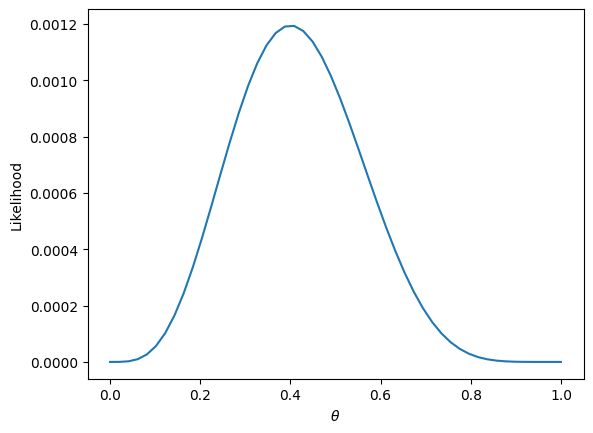

In [12]:
#| fig-alt: Line plot where theta is graphed against likelihood
thetas = np.linspace(0, 1)
plt.plot(thetas, (thetas**4)*(1-thetas)**6)
plt.xlabel(r"$\theta$")
plt.ylabel("Likelihood");

More generally, the likelihood for some Bernoulli($p$) random variable $Y$  is:

$$P(Y = y) = \begin{cases}
        1, \text{with probability }  p\\
        0, \text{with probability }  1 - p
    \end{cases} 
$$
    
Equivalently, this can be written in a compact way:

$$P(Y=y) = p^y(1-p)^{1-y}$$

- When $y = 1$, this reads $P(Y=y) = p$
- When $y = 0$, this reads $P(Y=y) = (1-p)$

In our example, a Bernoulli random variable is analogous to a single data point (e.g., one instance of a basketball team winning or losing a game). All together, our `games` data consists of many IID Bernoulli($p$) random variables. To find the likelihood of independent events in succession, simply multiply their likelihoods.

$$\prod_{i=1}^{n} p^{y_i} (1-p)^{1-y_i}$$

As with the coin example, we want to find the parameter $p$ that maximizes this likelihood. Earlier, we gave an intuitive graphical solution, but let's take the derivative of the likelihood to find this maximum.

At a first glance, this derivative will be complicated! We will have to use the product rule, followed by the chain rule. Instead, we can make an observation that simplifies the problem. 

Finding the $p$ that maximizes $$\prod_{i=1}^{n} p^{y_i} (1-p)^{1-y_i}$$ is equivalent to the $p$ that maximizes $$\text{log}(\prod_{i=1}^{n} p^{y_i} (1-p)^{1-y_i})$$

This is because $\text{log}$ is a strictly *increasing* function. It won't change the maximum or minimum of the function it was applied to. From $\text{log}$ properties, $\text{log}(a*b)$ = $\text{log}(a) + \text{log}(b)$. We can apply this to our equation above to get:

$$\underset{p}{\text{argmax}} \sum_{i=1}^{n} \text{log}(p^{y_i} (1-p)^{1-y_i})$$

$$= \underset{p}{\text{argmax}} \sum_{i=1}^{n} (\text{log}(p^{y_i}) + \text{log}((1-p)^{1-y_i}))$$

$$= \underset{p}{\text{argmax}} \sum_{i=1}^{n} (y_i\text{log}(p) + (1-y_i)\text{log}(1-p))$$

We can add a constant factor of $\frac{1}{n}$ out front. It won't affect the $p$ that maximizes our likelihood.

$$=\underset{p}{\text{argmax}}  \frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(p) + (1-y_i)\text{log}(1-p)$$

One last "trick" we can do is change this to a minimization problem by negating the result. This works because we are dealing with a *concave* function, which can be made *convex*.

$$= \underset{p}{\text{argmin}} -\frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(p) + (1-y_i)\text{log}(1-p)$$

Now let's say that we have data that are independent with different probability $p_i$. Then, we would want to find the $p_1, p_2, \dots, p_n$ that maximize $$\prod_{i=1}^{n} p_i^{y_i} (1-p_i)^{1-y_i}$$

Setting up and simplifying the optimization problems as we did above, we ultimately want to find:

$$= \underset{p}{\text{argmin}} -\frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(p_i) + (1-y_i)\text{log}(1-p_i)$$

For logistic regression, $p_i = \sigma(x^{\top}\theta)$. Plugging that in, we get:  

$$= \underset{p}{\text{argmin}} -\frac{1}{n} \sum_{i=1}^{n} y_i\text{log}(\sigma(x^{\top}\theta)) + (1-y_i)\text{log}(1-\sigma(x^{\top}\theta))$$

This is exactly our average cross-entropy loss minimization problem from before! 

Why did we do all this complicated math? We have shown that *minimizing* cross-entropy loss is equivalent to *maximizing* the likelihood of the training data.

- By minimizing cross-entropy loss, we are choosing the model parameters that are "most likely" for the data we observed.

Note that this is under the assumption that all data is drawn independently from the same logistic regression model with parameter $\theta$. In fact, many of the model + loss combinations we've seen can be motivated using MLE (e.g., OLS, Ridge Regression, etc.). In probability and ML classes, you'll get the chance to explore MLE further.  

## [BONUS] Gradient Descent for Logistic Regression
Let's define the following terms: 
$$\begin{align}
t_i &= \phi(x_i)^T \theta \\
p_i &= \sigma(t_i) \\
t_i &= \log(\frac{p_i}{1 - p_i}) \\
1 - \sigma(t_i) &= \sigma(-t_i) \\
\frac{d}{dt}  \sigma(t) &=  \sigma(t) \sigma(-t)
\end{align}
$$

Now, we can simplify the cross-entropy loss
$$\begin{align}
y_i \log(p_i) + (1 - y_i) \log(1 - p_i) &= y_i \log(\frac{p_i}{1 - p_i}) + \log(1 - p_i) \\
&= y_i \phi(x_i)^T + \log(\sigma(-\phi(x_i)^T \theta))
\end{align}
$$

Hence, the optimal $\hat{\theta}$ is 
$$\text{argmin}_{\theta} - \frac{1}{n} \sum_{i=1}^n (y_i \phi(x_i)^T + \log(\sigma(-\phi(x_i)^T \theta)))$$ 

We want to minimize $$L(\theta) = - \frac{1}{n} \sum_{i=1}^n (y_i \phi(x_i)^T + \log(\sigma(-\phi(x_i)^T \theta)))$$

So we take the derivative 
$$\begin{align}
\triangledown_{\theta} L(\theta) &= - \frac{1}{n} \sum_{i=1}^n \triangledown_{\theta} y_i \phi(x_i)^T + \triangledown_{\theta} \log(\sigma(-\phi(x_i)^T \theta)) \\
&= - \frac{1}{n} \sum_{i=1}^n y_i \phi(x_i) + \triangledown_{\theta} \log(\sigma(-\phi(x_i)^T \theta)) \\
&= - \frac{1}{n} \sum_{i=1}^n y_i \phi(x_i) + \frac{1}{\sigma(-\phi(x_i)^T \theta)} \triangledown_{\theta} \sigma(-\phi(x_i)^T \theta) \\
&= - \frac{1}{n} \sum_{i=1}^n y_i \phi(x_i) + \frac{\sigma(-\phi(x_i)^T \theta)}{\sigma(-\phi(x_i)^T \theta)} \sigma(\phi(x_i)^T \theta)\triangledown_{\theta} \sigma(-\phi(x_i)^T \theta) \\
&= - \frac{1}{n} \sum_{i=1}^n (y_i - \sigma(\phi(x_i)^T \theta)\phi(x_i))
\end{align}
$$

Setting the derivative equal to 0 and solving for $\hat{\theta}$, we find that there's no general analytic solution. Therefore, we must solve using numeric methods. 

### Gradient Descent Update Rule
$$\theta^{(0)} \leftarrow \text{initial vector (random, zeros, ...)} $$

For $\tau$ from 0 to convergence: 
$$ \theta^{(\tau + 1)} \leftarrow \theta^{(\tau)} - \rho(\tau)\left( \frac{1}{n} \sum_{i=1}^n \triangledown_{\theta} L_i(\theta) \mid_{\theta = \theta^{(\tau)}}\right) $$

### Stochastic Gradient Descent Update Rule
$$\theta^{(0)} \leftarrow \text{initial vector (random, zeros, ...)} $$

For $\tau$ from 0 to convergence, let $B$ ~ $\text{Random subset of indices}$. 
$$ \theta^{(\tau + 1)} \leftarrow \theta^{(\tau)} - \rho(\tau)\left( \frac{1}{|B|} \sum_{i \in B} \triangledown_{\theta} L_i(\theta) \mid_{\theta = \theta^{(\tau)}}\right) $$

## [BONUS] AUC of the Random Predictor

Recall that the best possible AUC = 1. On the other hand, a terrible model will have an AUC closer to 0.5. A **random predictor** randomly predicts $P(Y = 1 | x)$ to be uniformly between 0 and 1. This indicates the classifier is not able to distinguish between positive and negative classes, and thus, randomly predicts one of the two. 

```{image} images/roc_curve_worst_predictor.png
:alt: '' 
:width:700
```
We can illustrate this by comparing different thresholds and seeing their points on the ROC curve.

```{image} images/roc_curve_worse_predictor_differing_T.png
:alt: On average, if your dataset is size n (wuth n_1 true class 1's and n_0's true class 0's)... if T=0.5, the point on the ROC curve is (0.5, 0.5)... if T=0.8, the point on the ROC curve is (0.2, 0.2)... if T-0.3, the point on the ROC curve is (0.7, 0.7)
:width: 700
```
